In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

In [3]:
data = pd.read_csv("Datasets/cybersecurity_intrusion_data.csv")
data

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9532,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1
9533,SID_09534,380,TCP,3,182.848475,NaN,0.408485,0,Chrome,0,0
9534,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0
9535,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0


# Descriptive analysis of your data

### Analysis of numerical values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


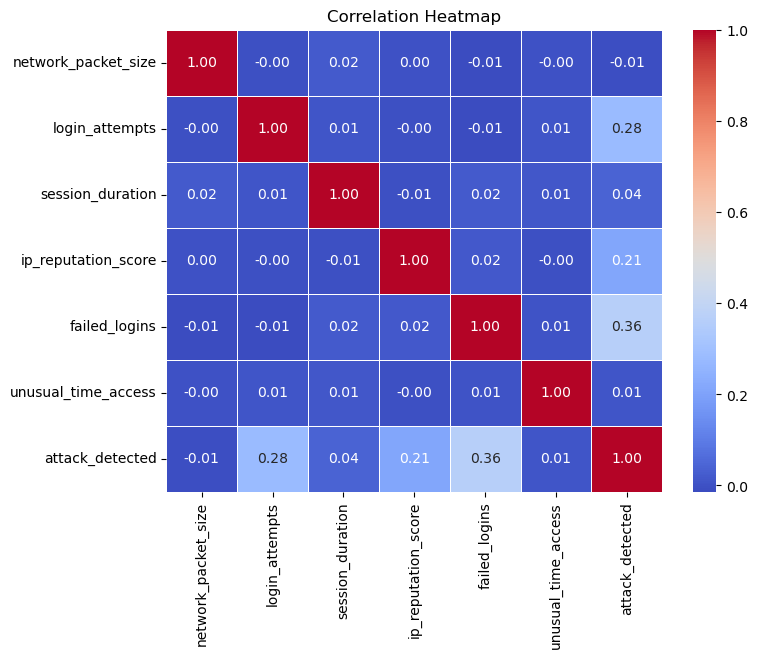

In [5]:
# Correlation matrix
num_values = ["network_packet_size", "login_attempts", "session_duration","ip_reputation_score","failed_logins","unusual_time_access","attack_detected"]
matrix = data[num_values].corr()
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
# We can observe that login_attempts, ip_reputation_score, failed_login are the most correlated features to attack_detected

In [7]:
### Distribution graphs
relevant_columns = [col for col in data.columns if col not in ['attack_detected', 'session_id']]

print("\nColonnes pertinentes pour la visualisation :")
print(relevant_columns)

# Catégoriser les colonnes
numerical_columns = []
categorical_columns = []

for col in relevant_columns:
    if data[col].dtype in ['int64', 'float64']:
        numerical_columns.append(col)
    # Vérifier le type 'object' et s'il contient des valeurs non numériques
    elif data[col].dtype == 'object':
        if data[col].apply(lambda x: isinstance(x, str)).any():
            categorical_columns.append(col)
        else:
            numerical_columns.append(col) # Traiter comme numérique si tout est numérique
    elif data[col].dtype == 'category':
        categorical_columns.append(col)


print("\nColonnes numériques :")
print(numerical_columns)
print("\nColonnes catégorielles :")
print(categorical_columns)


Colonnes pertinentes pour la visualisation :
['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access']

Colonnes numériques :
['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']

Colonnes catégorielles :
['protocol_type', 'encryption_used', 'browser_type']


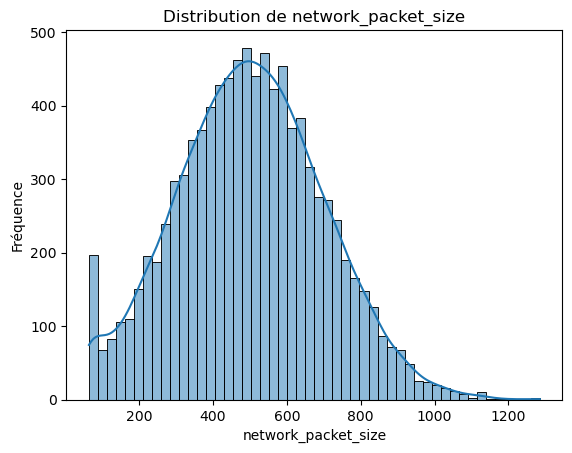

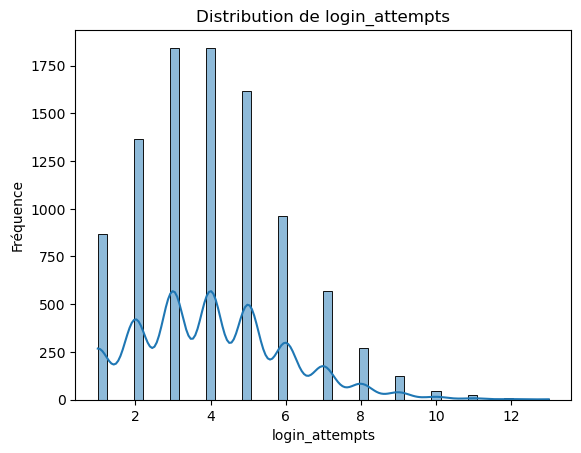

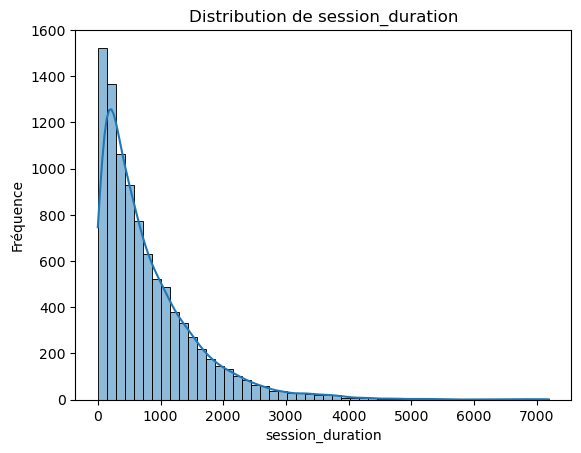

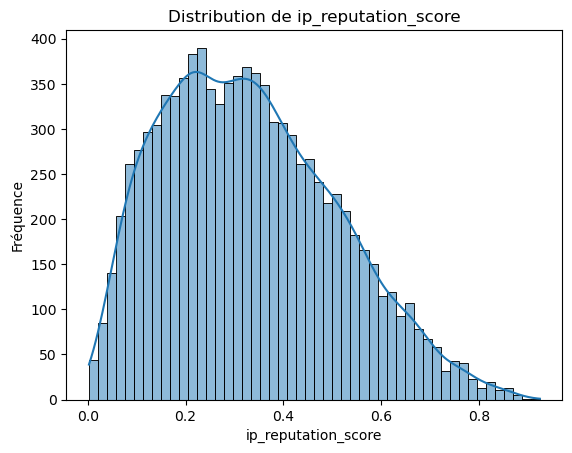

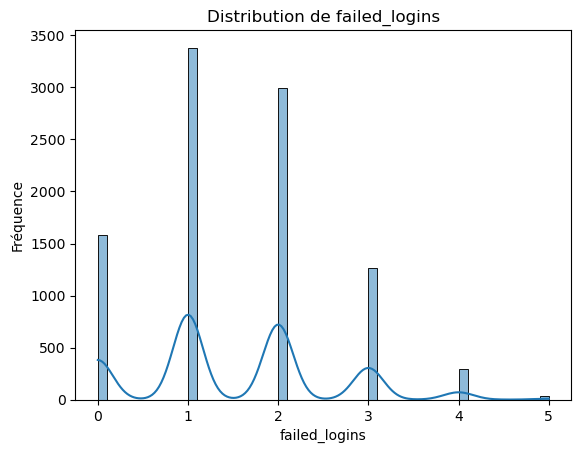

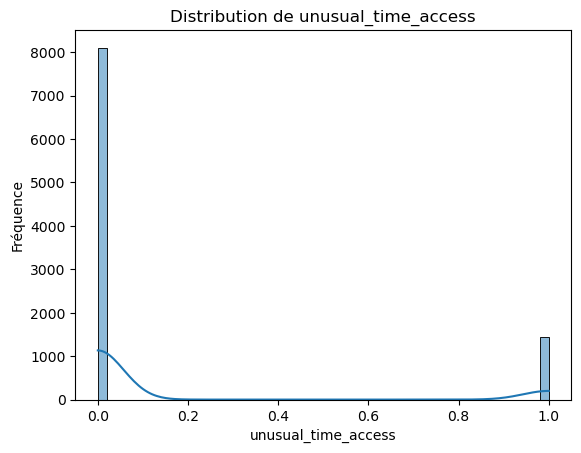

In [8]:
# Générer les histogrammes pour les colonnes numériques
for col in numerical_columns:
    sns.histplot(data=data, x=col, bins=50, kde=True)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

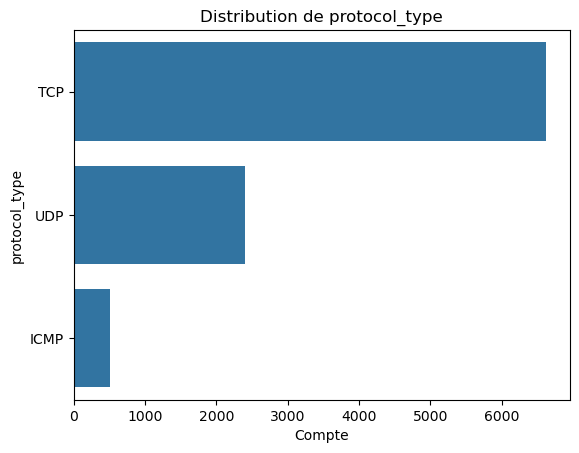

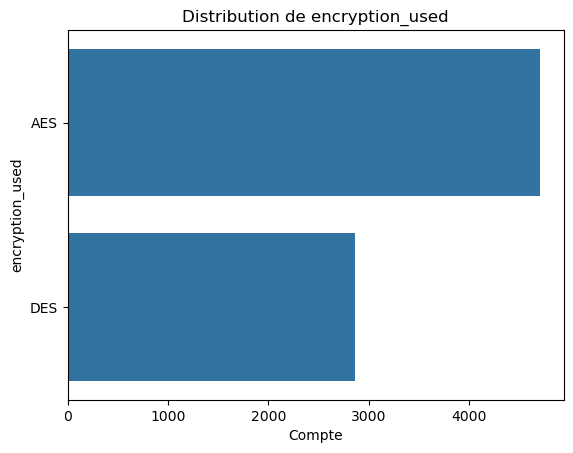

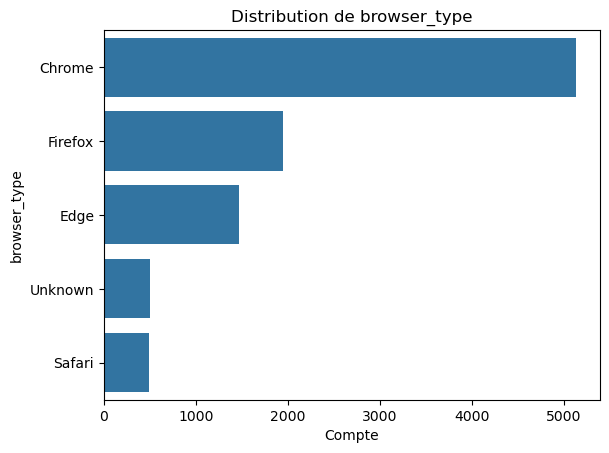

In [9]:
# Générer les graphiques à barres pour les colonnes catégorielles
for col in categorical_columns:
    # Utiliser 'y=col' pour les barres horizontales si les noms sont longs
    # Triez pour afficher les plus fréquents en premier
    sns.countplot(data=data, y=col, order=data[col].value_counts().index)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Compte')
    plt.ylabel(col)
    plt.show()

In [10]:
df = pd.DataFrame(data=data.values, columns=data.columns)

In [ ]:
# Convert the numerical 'attack_detected' column (0 or 1)
# into a categorical string ('Attack' or 'Normal') for the legend.
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attaque' if x == 1 else 'Normal')

# --- Data Preparation ---
# Select a subset of columns to plot.
# A full pairplot with all columns would be too large and unreadable.
columns_to_plot = [
    'ip_reputation_score',
    'login_attempts',
    'failed_logins',
    'network_packet_size',
    'attack_status' # This column will be used for coloring ('hue')
]

# Create a new DataFrame from the selected columns.
# .copy() is used to avoid a 'SettingWithCopyWarning' from pandas.
df_subset = df[columns_to_plot].copy()

# --- Create and Display the Plot ---
# 'sns.pairplot' creates a grid of scatterplots for every pair of columns.
# The diagonal plots are histograms (or density plots) for each variable.
g = sns.pairplot(
    df_subset, 
    hue='attack_status', # Color the points based on the 'attack_status' column
    palette={'Normal': '#5CB85C', 'Attaque': '#D9534F'}, # Assign custom colors (Green/Red)
    plot_kws={'alpha': 0.3, 's': 15} # 'plot_kws' arguments:
                                     # 'alpha=0.3' makes points 30% transparent to see overlaps
                                     # 's=15' sets the size of the points
)


g.fig.suptitle("Pairplot Matrix by Attack Status", y=1.03, fontsize=16)
plt.show()

In [ ]:
# The pairplot analysis highlights clear differences between normal and attack instances. 
# Features such as ip_reputation_score, login_attempts, and failed_logins show strong discriminative power: attack samples tend to have lower IP reputation scores 
# and higher login attempts and failures. 
# In contrast, network_packet_size shows little distinction between the two classes. 
# The observed correlation between login_attempts and failed_logins is coherent. 
# Overall, these insights indicate that the dataset is well-suited for binary supervised learning

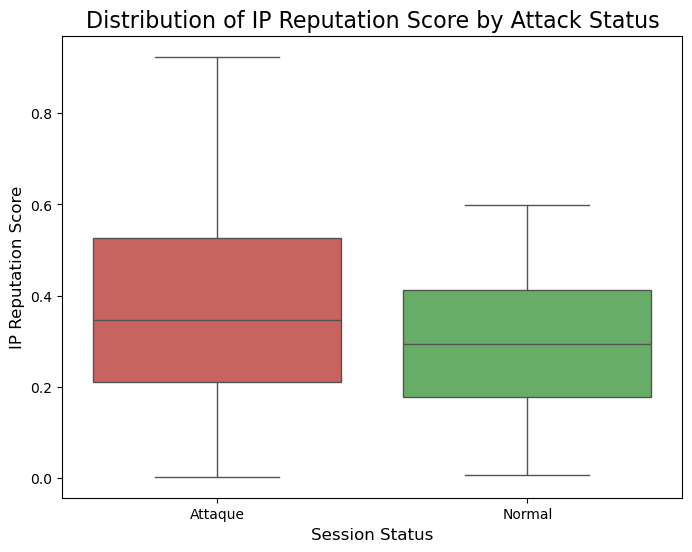

In [ ]:
# Convert the 'attack_detected' column (0 or 1) into a string
# This makes the plot labels ('Attack' / 'Normal') more readable
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attaque' if x == 1 else 'Normal')

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df,                      
    x='attack_status',           
    y='ip_reputation_score',    
    
    # 1. Assign the x-variable ('attack_status') to 'hue'
    hue='attack_status',
    palette={'Normal': '#5CB85C', 'Attaque': '#D9534F'}, 
    legend=False                  

)

plt.title('Distribution of IP Reputation Score by Attack Status', fontsize=16)
plt.xlabel('Session Status', fontsize=12)
plt.ylabel('IP Reputation Score', fontsize=12)
plt.show()

This box plot compares the IP Reputation Score for "Normal" (green) and "Attaque" (red) sessions, revealing that attacks are strongly correlated with higher reputation scores. We can clearly see the red box (Attaque) is positioned significantly higher on the graph, with a median score around 0.38, compared to the green box (Normal) which has a lower median of approximately 0.25. This difference demonstrates that ip_reputation_score is a valuable indicator for identifying malicious activity, as a high score is a major red flag, even though outliers show some attacks can still come from low-reputation IPs.

### Analysis of the categorial values

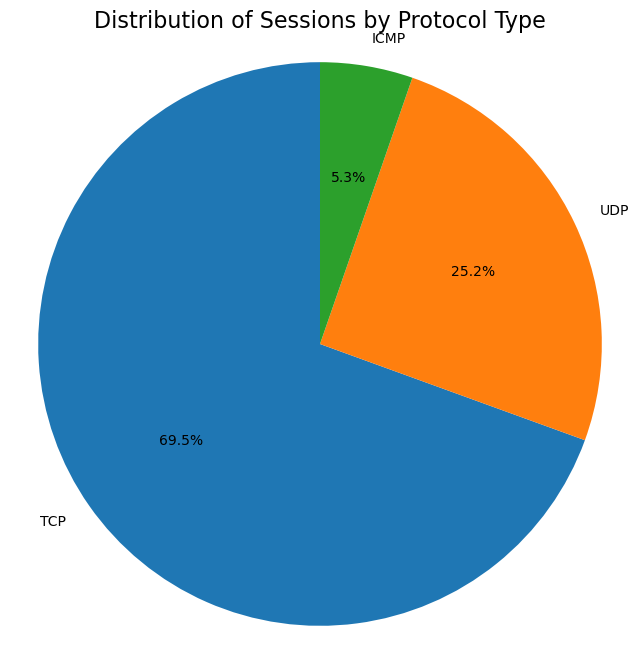

In [ ]:
# --- Pie Chart 1: Protocol Type ---

# 1. Get the data for the pie chart
# .value_counts() calculates the size of each slice
protocol_counts = df['protocol_type'].value_counts()

# 2. Get the labels (e.g., 'TCP', 'UDP', 'ICMP')
protocol_labels = protocol_counts.index

# 3. Get the numerical values (the counts for each slice)
protocol_sizes = protocol_counts.values

plt.figure(figsize=(8, 8)) # Set the figure size to be a square
plt.pie(
    protocol_sizes,      # The numerical values for each slice
    labels=protocol_labels, # The text labels for each slice
    autopct='%1.1f%%',   # Format to show percentages (e.g., '10.1%')
    startangle=90        # Start the first slice at the 90-degree (top) position
)

plt.title('Distribution of Sessions by Protocol Type', fontsize=16)
plt.axis('equal') 
plt.show()

In [ ]:
# Here we see that TCP is the dominant protocol type in the dataset, accounting for the majority of sessions. However, there is also a significant portion of UDP and a smaller fraction of ICMP traffic.
# From this point, we might consider analyzing how attack patterns differ across these protocol types in future analyses.

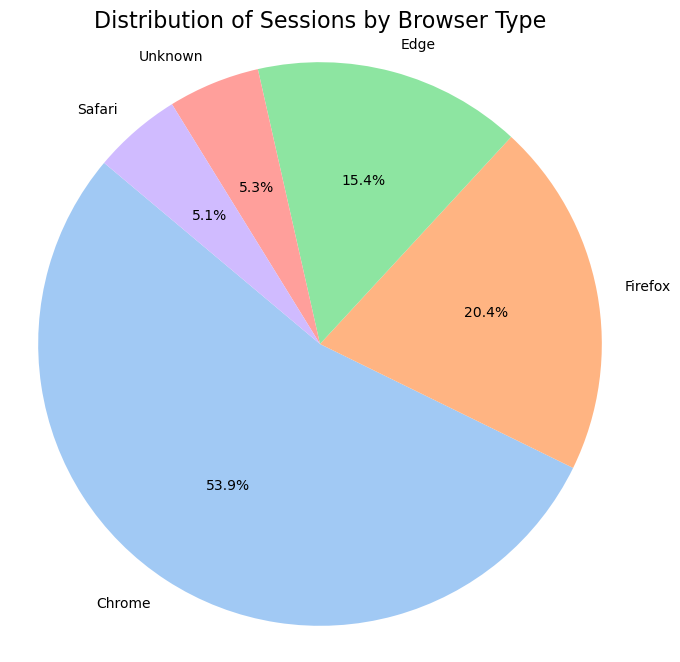

In [ ]:
# --- Pie Chart 2: Browser Type (with explode) ---

# 1. Get the data
browser_counts = df['browser_type'].value_counts()
browser_labels = browser_counts.index
browser_sizes = browser_counts.values


colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(8, 8))
plt.pie(
    browser_sizes,
    labels=browser_labels,
    autopct='%1.1f%%',
    startangle=140,       # Start at a different angle
    colors=colors         # Apply the custom color palette
)


plt.title('Distribution of Sessions by Browser Type', fontsize=16)
plt.axis('equal')
plt.show()

In [ ]:
# Here we observe that Chrome is the most commonly used browser in the dataset, followed by Firefox and Safari. Edge and Opera have smaller shares. 
# This distribution may reflect general user preferences or specific targeting by attackers. Nothing can be concluded yet without further analysis.

# Preprocessing

### Cleaning data

In [ ]:
# Checking for null values or NaN
print("Number of Null :\n",data.isnull().sum())

# Dropping the null values
data_cleaned = data.dropna(axis=0)
print("\nNumber of Null :\n",data_cleaned.isnull().sum())

# session_id here is not relevant
data_cleaned = data_cleaned.drop("session_id", axis=1)

Number of Null :
 session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

Number of Null :
 session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64


In [ ]:
X, y = data_cleaned.drop("attack_detected", axis=1), data_cleaned["attack_detected"]

### Checking class distribution

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


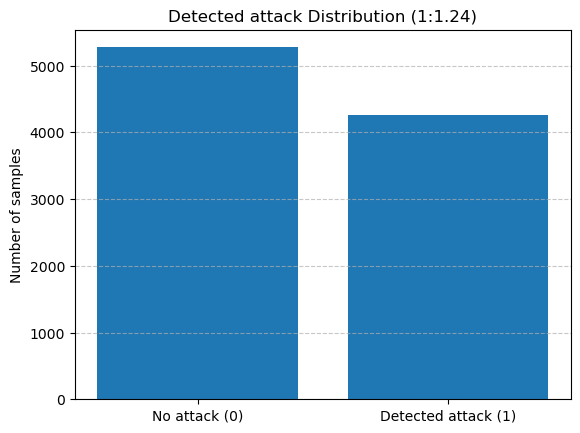

In [ ]:
class_counts = data['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)
minority = class_counts.min()
majority = class_counts.max()
ratio = majority/minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['No attack (0)', 'Detected attack (1)'], class_counts)
plt.title(f"Detected attack Distribution (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We have a slight imbalance (the ratio is 1.24, close to 1) that we can correct by either undersampling the minority class 0 or oversampling the majority class 1, with random under/oversampling or SMOTE
Undersampling could make us to lose some valuables informations while the oversampling could create points and overfitting if a class gap between is too big.
Since we only have about 1000 points of difference, we will use oversampling on the training set. We don't have that much points to begin with so removing some could lead to loss of information.

### Transforming categorial data into numerical data
We need to transform ['protocol_type', 'encryption_used', 'browser_type'] into numeric data.
As these categories has at most five categories, we can use the one-hot encoding (which consists of having two binary columns describing it's category 1 and if it's category 2 (and more).
We could introduce labels meaning we would associate number to each category of a feature. Although, it could introduce ordinal features in the said feature which means there would be an order of importance in the features when there isn't in reality (Chrome, Edge or other browser aren't more important than the others for example) and influence the predicition.

In [ ]:
X, y = data_cleaned.drop("attack_detected", axis=1), data_cleaned["attack_detected"]

# encryption_used
dummies = pd.get_dummies(X['encryption_used'])
X = pd.concat([X, dummies], axis=1)
X.drop("encryption_used", axis=1, inplace=True)

# browser_type
dummies = pd.get_dummies(X['browser_type'])
X = pd.concat([X, dummies], axis=1)
X.drop("browser_type", axis=1, inplace=True)

# protocol_type
dummies = pd.get_dummies(X['protocol_type'])
X = pd.concat([X, dummies], axis=1)
X.drop("protocol_type", axis=1, inplace=True)

In [ ]:
X

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,AES,DES,Chrome,Edge,Firefox,Safari,Unknown,ICMP,TCP,UDP
0,599,4,492.983263,0.606818,1,0,False,True,False,True,False,False,False,False,True,False
1,472,3,1557.996461,0.301569,0,0,False,True,False,False,True,False,False,False,True,False
2,629,3,75.044262,0.739164,2,0,False,True,True,False,False,False,False,False,True,False
3,804,4,601.248835,0.123267,0,0,False,True,False,False,False,False,True,False,False,True
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9528,535,7,50.518476,0.767659,1,1,False,True,False,True,False,False,False,False,True,False
9531,746,7,315.151758,0.190059,3,0,False,True,True,False,False,False,False,False,True,False
9532,194,3,226.049889,0.517737,3,0,True,False,True,False,False,False,False,True,False,False
9534,664,5,35.170248,0.359200,1,0,True,False,False,False,True,False,False,False,True,False


### Splitting into train and test datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
# We begin with test_size=0.20 and can fine-tuning it later for better results

### MinMaxScaler
We need to normalize or standardize our features, as session duration is easily has 3 to 4 digit when failed_logins shows no more than one. We need espicially normalized values to use LogisticRegression
As shown by the visualisation step, most of the numerical features doesn't follow a gaussian distribution, beside reputation_score and network_packets_time. We will normalize the data, because StandardScaler assumes that our data follows a gaussian distribution.

We make sure that it only affect numerical values, binary features need to stay as they are.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_columns])
X_train[numerical_columns], X_test[numerical_columns] = scaler.transform(X_train[numerical_columns]), scaler.transform(X_test[numerical_columns])

In [ ]:
X_train # We have normalized our numerical features

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,AES,DES,Chrome,Edge,Firefox,Safari,Unknown,ICMP,TCP,UDP
417,0.375921,0.000000,0.115964,0.260213,0.2,0.0,False,True,True,False,False,False,False,False,True,False
6782,0.366093,0.083333,0.447440,0.362926,0.0,0.0,False,True,True,False,False,False,False,False,True,False
8042,0.120393,0.250000,0.109494,0.230943,0.2,0.0,True,False,False,False,False,False,True,False,True,False
6499,0.298116,0.166667,0.008855,0.872015,0.4,0.0,False,True,True,False,False,False,False,False,True,False
3506,0.409500,0.083333,0.019021,0.072342,0.4,0.0,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,0.469287,0.166667,0.152435,0.351883,0.4,0.0,True,False,True,False,False,False,False,False,True,False
6602,0.506143,0.416667,0.512547,0.342231,0.4,0.0,True,False,True,False,False,False,False,False,False,True
6808,0.294840,0.166667,0.006736,0.257168,0.8,1.0,True,False,True,False,False,False,False,False,True,False
1075,0.276003,0.333333,0.266441,0.509010,0.4,0.0,True,False,True,False,False,False,False,False,True,False


In [ ]:
### Re-sampling
# As said higher in the notebook, we are going to use SMOTE to sample more of the minority class.

In [ ]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)
X_train, y_train = X_res, y_res

# And we check the class distribution again
class_counts = y_train.value_counts()
print("Class distribution:\n", class_counts)
minority = class_counts.min()
majority = class_counts.max()
ratio = majority/minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['No attack (0)', 'Detected attack (1)'], class_counts)
plt.title(f"Detected attack Distribution (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Formulation of the problem

Having analyzed our data and pre-processed it, we have come to the conclusion that our different session IDs suffer countless attacks, an occurrence that we wish to minimize as soon as possible. To study this situation further and find a solution, we have formulated the following problem:

### By using this data, can we predict attacks that are currently happening on our sessions?

In order to predict, we will base our studies on the following variables:

for our 'X' variables: session_id, network_packet_size, protocol_type, login_attempts, session_duration, encryption_used, ip_reputation_score, failed_logins, browser_type, unusual_time_access

for our predict (or 'Y') variable: attack_detected 

# Implementation of a model
To choose, we need to experiment with several algorithms and create multiple pipelines, we will begin with the LogisticRegression

Accuracy: 0.7313531353135313
AUC-ROC Score of Logistic Regression is : 0.7256180821898475
Confusion Matrix:
 [[654 187]
 [220 454]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76       841
           1       0.71      0.67      0.69       674

    accuracy                           0.73      1515
   macro avg       0.73      0.73      0.73      1515
weighted avg       0.73      0.73      0.73      1515



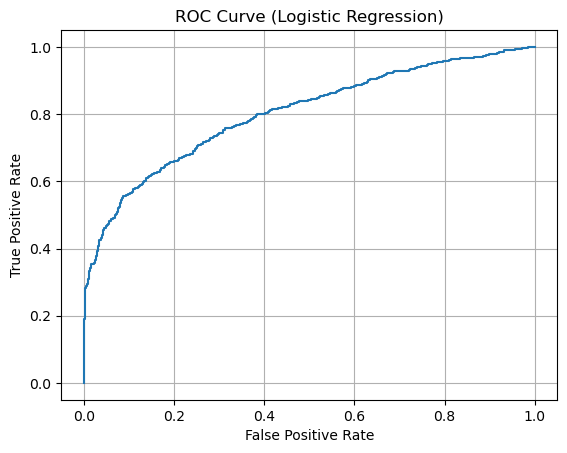

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]


### Metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
 
print("Accuracy:", accuracy)
print("AUC-ROC Score of Logistic Regression is :", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

In [ ]:
# We have 0.73 in all metrics, which seems to show that we don't have overfitting but can do better.